# Pytorch

In this tutorial we will use `Pytorch` to solve a simple _regression problem_

## 0) Importing the libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, TensorDataset
import time, sys, os
import matplotlib.pyplot as plt
import pandas as pd
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms

## 1) Generating the dataset

In [2]:
#Create Dataset 
def generate_data(a, b, num_examples):  
    '''
    Generate y = a x + b + noise
    '''

    x = np.random.uniform(0, 1, num_examples)
    y = a*x + b
    y += np.random.normal(0, 0.05, num_examples)

    df = pd.DataFrame(data = np.array([x, y]).T, columns = ['x', 'y'])
    
    return df

In [3]:
df = generate_data(0.5, 4.0, 2000)
df.head(5)

,x,y
0,0.164218,3.982775
1,0.797218,4.309355
2,0.937852,4.484632
3,0.365781,4.124644
4,0.325644,4.148302


Looking at the data

Text(0, 0.5, 'y')

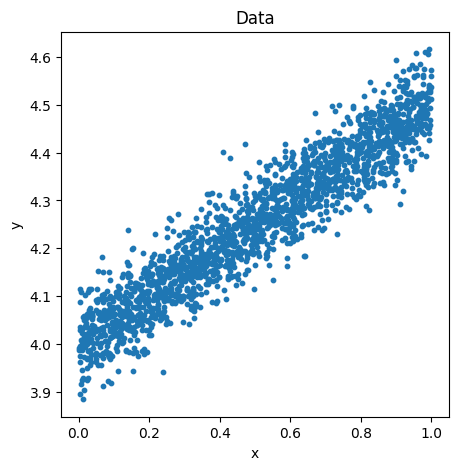

In [4]:
plt.figure(dpi = 100, figsize = (5, 5))
plt.title('Data')
plt.scatter(df['x'], df['y'], s = 10)
plt.xlabel('x')
plt.ylabel('y')

## 2) Transforming the dataset to use it in `pytorch`

In [5]:
def transform_dataset(df, frac_train, frac_val, batch_size):
    '''
    frac_train: fraction of the dataset to use in the training
    frac_val:   fraction of the dataset to use in the validation
    batch_size: number of samples to work through before updating the internal model parameters
    '''

    #Randomizing the dataset
    df = df.sample(frac = 1)

    #Getting the training, validation, and testing sets
    x_train = np.array( [ df['x'].iloc[:int(df.shape[0]*frac_train)] ] ).T
    y_train = np.array( [ df['y'].iloc[:int(df.shape[0]*frac_train)] ] ).T

    x_val = np.array( [ df['x'].iloc[int(df.shape[0]*frac_train):int(df.shape[0]*(frac_train + frac_val))] ] ).T
    y_val = np.array( [ df['y'].iloc[int(df.shape[0]*frac_train):int(df.shape[0]*(frac_train + frac_val))] ] ).T

    x_test = np.array( [ df['x'].iloc[int(df.shape[0]*(frac_train + frac_val)):] ] ).T
    y_test = np.array( [ df['y'].iloc[int(df.shape[0]*(frac_train + frac_val)):] ] ).T

    #Getting the statistics from the training set 
    mean = np.mean(x_train, axis = 0)
    std = np.std(x_train, axis = 0)
    min = np.mean(y_train, axis = 0)
    max = np.std(y_train, axis = 0)

    #Tranforming the training set
    x_train = (x_train - mean)/std
    x_val = (x_val - mean)/std
    x_test = (x_test - mean)/std

    y_train = (y_train - min)/(max - min)
    y_val = (y_val - min)/(max - min)
    y_test = (y_test - min)/(max - min)

    #Converting to torch reshaping
    x_train = torch.from_numpy(x_train.reshape(-1, 1)).float()
    y_train = torch.from_numpy(y_train.reshape(-1, 1)).float()

    x_val = torch.from_numpy(x_val.reshape(-1, 1)).float()
    y_val = torch.from_numpy(y_val.reshape(-1, 1)).float()

    x_test = torch.from_numpy(x_test.reshape(-1, 1)).float()
    y_test = torch.from_numpy(y_test.reshape(-1, 1)).float()

    #Converting to tensor dataset
    dataset_train = TensorDataset(x_train, y_train)
    dataset_val = TensorDataset(x_val, y_val)
    dataset_test = TensorDataset(x_test, y_test)

    #Organizing in batches
    train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size)
    val_loader = DataLoader(dataset = dataset_val, batch_size = batch_size)
    test_loader = DataLoader(dataset = dataset_test, batch_size = batch_size)

    return train_loader, val_loader, test_loader, x_test, y_test, mean, std, max, min

In [6]:
train_loader, val_loader, test_loader, x_test, y_test, mean, std, max, min = transform_dataset(df, 0.8, 0.1, 100)

## 3) Setting the CPU/CPU to use

In [7]:
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 4) Defining the model

In [8]:
class model(nn.Module):
  def __init__(self):

    super(model, self).__init__()
      
    self.layer1 = nn.Linear(1, 8)
    self.layer2 = nn.Linear(8, 16)
    self.layer3 = nn.Linear(16, 1)
    self.ReLU = nn.ReLU()

  #Forward pass
  def forward(self, x):
    '''
    Define the architecture at the same time as compute y
    '''
    x = self.ReLU(self.layer1(x))
    x = self.ReLU(self.layer2(x))
    y = self.layer3(x)
      
    return y

Instantiating the model

In [9]:
model = model().to(device)
model

model(
  (layer1): Linear(in_features=1, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (ReLU): ReLU()
)

Computing the number of parameters of the model

In [10]:
network_total_params = sum(p.numel() for p in model.parameters())

In [11]:
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 177


## 5) Defining the `optimizer` and `loss function`:

* **optimizer:** algorithm that adjust the model parameters during training to minimize the loss function
* **loss function:** a mathematical function that quantifies the difference between predicted and actual values

In [12]:
optimizer = torch.optim.Adam(model.parameters())
loss_func = torch.nn.MSELoss()

## 6) Training and validating the model

In [13]:
epochs = 100 #Number of steps to train the model

lloss_train = []
lloss_val = []
for i in range(epochs):
  aux_train = 0
  model.train()  #Telling the model we are training :p
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    prediction = model(x)
    tloss = loss_func(prediction, y) 
    optimizer.zero_grad() #set the gradients to zero before starting to do backpropagation (i.e., updating the weights and biases)
    tloss.backward() #calculate the gradient during the backward pass in the neural network       
    optimizer.step() #performs a single optimization step (parameter update)
    aux_train += tloss.item()
  lloss_train.append( aux_train/len(train_loader) )     
  if i % 10 == 0:
    print(f"Epoch {i} | Train Loss {aux_train/len(train_loader)}")

  aux_val = 0
  model.eval() #Telling the model we are testing :p
  for x, y in val_loader:
    x = x.to(device)
    y = y.to(device)
    prediction = model(x)
    vloss = loss_func(prediction, y) 
    aux_val += vloss.item()
  lloss_val.append( aux_val/len(val_loader) )
  if i % 10 == 0:
    print(f"Epoch {i} | Val Loss {aux_val/len(val_loader)}")

Epoch 0 | Train Loss 0.00041755122038011905
Epoch 0 | Val Loss 0.00029364209331106395
Epoch 10 | Train Loss 0.00015554637957393425
Epoch 10 | Val Loss 0.000154826368088834
Epoch 20 | Train Loss 0.000151080747400556
Epoch 20 | Val Loss 0.00015239065396599472
Epoch 30 | Train Loss 0.0001509508856543107
Epoch 30 | Val Loss 0.000151840977196116
Epoch 40 | Train Loss 0.00015111319453353644
Epoch 40 | Val Loss 0.00015168294339673594
Epoch 50 | Train Loss 0.00015137776244955603
Epoch 50 | Val Loss 0.00015176579472608864
Epoch 60 | Train Loss 0.00015161107330641244
Epoch 60 | Val Loss 0.00015221021021716297
Epoch 70 | Train Loss 0.00015171886661846656
Epoch 70 | Val Loss 0.00015300965606002137
Epoch 80 | Train Loss 0.00015175698490565992
Epoch 80 | Val Loss 0.00015392035857075825
Epoch 90 | Train Loss 0.00015176833039731719
Epoch 90 | Val Loss 0.00015467148477910087


## 7) Taking a look at the loss function

Here we can see if our model is **overfitting**, **underfitting** or doing well

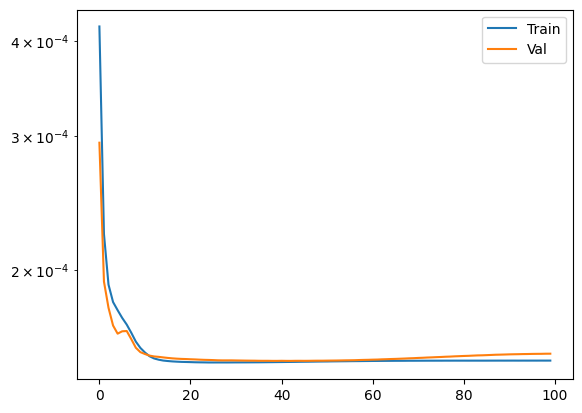

In [14]:
plt.figure(dpi = 100)
plt.plot(lloss_train, label = 'Train')
plt.plot(lloss_val, label = 'Val')
plt.legend()
plt.yscale('log')

## 8) Testing the model in the test set

In [15]:
lloss_test = []
preds = []
yss = []
for x, y in test_loader:
  out = model( x.to(device))
  preds.append( out.detach().cpu().numpy() )
  yss.append( np.array( y ) )
  loss = loss_func(out, torch.from_numpy( np.array(y)[:, 0] ).float().to(device) )
lloss_test.append( loss.data.cpu().numpy() )

/Users/natalidesanti/venv-metal/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Arranging the batches results

In [16]:
new_preds = np.concatenate( [preds[i] for i in range(len(preds))])
new_yss = np.concatenate( [yss[i] for i in range(len(yss))])
new_preds.shape, new_yss.shape

((200, 1), (200, 1))

In [18]:
df = pd.DataFrame()

df["y_truth"] = new_yss[:, 0]*std + mean
df["y_pred"] = new_preds[:, 0]*std + mean

### 8.1) Computing the MSE for the test set

In [17]:
loss_test = np.mean(lloss_test)
loss_test

0.002354999

### 8.2) Looking at the predictions for the test set

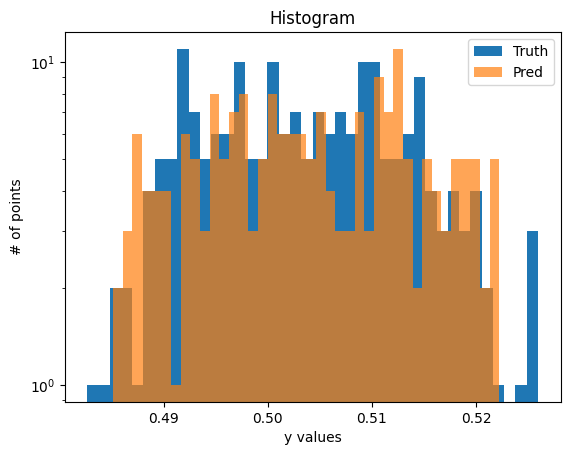

In [19]:
plt.figure(dpi = 100)
plt.title('Histogram')
plt.hist(df["y_truth"], bins = 40, label = 'Truth')
plt.hist(df["y_pred"], bins = 40, label = 'Pred', alpha = 0.7)
plt.ylabel('# of points')
plt.xlabel('y values')
plt.legend()
plt.yscale('log')

Text(0.5, 0, 'Truth')

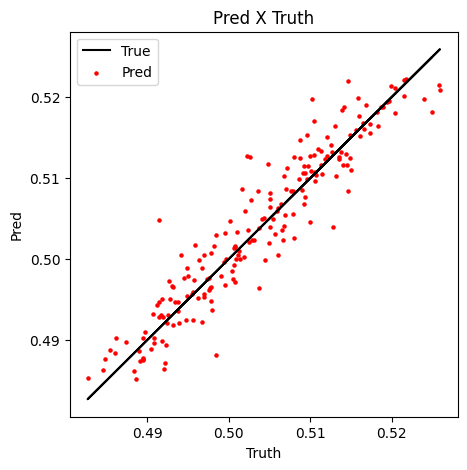

In [20]:
plt.figure(dpi = 100, figsize = (5, 5))
plt.title('Pred X Truth')
plt.plot(df["y_truth"], df["y_truth"], color = 'black', label = 'True')
plt.scatter(df["y_truth"], df["y_pred"], c = 'r', s = 5, label = 'Pred')
plt.legend()
plt.ylabel('Pred')
plt.xlabel('Truth')